# Libraries

In [1]:
import requests
import os
import yaml
os.chdir('../')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)
pd.options.display.max_columns = 50
pd.options.display.precision = 2

In [4]:
from cloudant.view import View
from cloudant.client import Cloudant
from cloudant.document import Document

In [5]:
def unfold_keys(df):
    df = df.copy()
    key_column = 'key'
    for i in range(0, len(df.loc[0,key_column])):
        df.insert(i, 'level_{}'.format(i+1), df[key_column].apply(lambda x: x[i]))
    del df[key_column]
    return df

In [6]:
with open("config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

In [7]:
cfg = cfg['COUCHDB']
client = Cloudant(cfg['user'], cfg['password'], url=cfg['host'])
client.connect()
tweets_db = client[cfg['tweets_db']]
aurin_db = client[cfg['aurin_db']]
ddoc = Document(tweets_db, '_design/sentiment_analysis')

In [11]:
tweets_db.doc_count()

198764

In [10]:
for document in tweets_db.doc_count():
    print(type(document))

TypeError: 'int' object is not iterable

# Load data

## Load tweets counters

In [8]:
view = View(ddoc, 'geo_sentiment_counts', )
with view.custom_result(group=True, stale='update_after') as rslt:
    df = pd.DataFrame.from_records(rslt.all())

In [9]:
geo_sentiment_columns = ['sa4_area', 'gccsa_area', 'state', 'sentiment', 'tweets_count']
data_df = unfold_keys(df)
data_df.dropna(inplace=True)
data_df.columns = geo_sentiment_columns
data_df.sort_values('tweets_count', ascending=False, inplace=True)
data_df.set_index(geo_sentiment_columns[:-1], inplace=True)

In [10]:
sentiment_df = data_df.unstack(level=-1, fill_value=0)

In [11]:
gccsa_sentiment_df = sentiment_df.groupby(level='gccsa_area').sum()
gccsa_sentiment_df.columns = gccsa_sentiment_df.columns.droplevel(0)
sorted_columns = list(gccsa_sentiment_df.sum().sort_values(ascending=False).index.values)
gccsa_sentiment_df = gccsa_sentiment_df[sorted_columns]

In [12]:
sa4_sentiment_df = sentiment_df.groupby(level='sa4_area').sum()
sa4_sentiment_df.columns = sa4_sentiment_df.columns.droplevel(0)
sorted_columns = list(sa4_sentiment_df.sum().sort_values(ascending=False).index.values)
sa4_sentiment_df = sa4_sentiment_df[sorted_columns]

## Load Aurin Data

### SA4 Median Income

In [13]:
data = [item['properties'] for item in aurin_db['SA4_median_income']['features']]
sa4_median_income_df = pd.DataFrame.from_records(data).set_index('sa4_name16')
del sa4_median_income_df['sa4_code16']
sa4_median_income_df.head()

,median_tot_fam_inc_weekly,median_tot_prsnl_inc_weekly
sa4_name16,,
Capital Region,1561,655
Central Coast,1560,600
Central West,1473,594
Coffs Harbour - Grafton,1249,520
Far West and Orana,1386,590


### SA4_Labour_Force

In [14]:
data = [item['properties'] for item in aurin_db['SA4_Labour_Force']['features']]
sa4_labour_force_df = pd.DataFrame.from_records(data).set_index('sa4_name16')
del sa4_labour_force_df['sa4_code16']
sa4_labour_force_df.head()

,p_tot_emp_tot,p_tot_lf_tot,p_tot_unemp_tot,p_unem_look_ptw_tot
sa4_name16,,,,
Capital Region,97339,102324,4985,2028
Central Coast,139593,149701,10105,4276
Central West,86287,91992,5707,2134
Coffs Harbour - Grafton,52076,56542,4464,1779
Far West and Orana,46707,50234,3527,1215


### GCCSA Median Income

In [15]:
data = [item['properties'] for item in aurin_db['GCCSA_median_income']['features']]
gccsa_median_income_df = pd.DataFrame.from_records(data).set_index('gcc_name16')
del gccsa_median_income_df['gcc_code16']
gccsa_median_income_df

,median_tot_fam_inc_weekly,median_tot_hhd_inc_weekly,median_tot_prsnl_inc_weekly
gcc_name16,,,
Greater Sydney,1988,1750,719
Rest of NSW,1449,1168,584
Greater Melbourne,1826,1542,673
Rest of Vic.,1418,1124,576
Greater Brisbane,1821,1562,703
Rest of Qld,1511,1271,624
Greater Adelaide,1591,1265,617
Rest of SA,1307,1027,550
Greater Perth,1955,1643,728


### GCCSA_Labour_Force

In [16]:
data = [item['properties'] for item in aurin_db['GCCSA_Labour_Force']['features']]
gccsa_labour_force_df = pd.DataFrame.from_records(data).set_index('gcc_name16')
del gccsa_labour_force_df['gcc_code16']
gccsa_labour_force_df

,p_emp_awy_f_wrk_tot,p_tot_lf_tot,p_tot_tot,p_tot_unemp_tot
gcc_name16,,,,
Rest of NSW,42391,1182580,2158275,78414
Greater Sydney,65069,2418899,3923700,146187
Rest of Vic.,27008,657811,1173346,39226
Greater Melbourne,64518,2269119,3665515,153625
Greater Brisbane,34817,1159423,1826402,85640
Rest of Qld,37980,1148556,1952257,89036
Rest of SA,7038,169447,311230,11133
Greater Adelaide,21442,636107,1069769,49051
Greater Perth,33645,1001684,1573536,81482


## GCCSA Data

In [26]:
gccsa_df = gccsa_sentiment_df.join(gccsa_median_income_df).join(gccsa_labour_force_df)
gccsa_df.to_csv('gccsa.csv')

## SA4 Data

In [27]:
sa4_df = sa4_sentiment_df.join(sa4_median_income_df).join(sa4_labour_force_df)
sa4_df.to_csv('sa4.csv')

In [19]:
#data_df.corr()

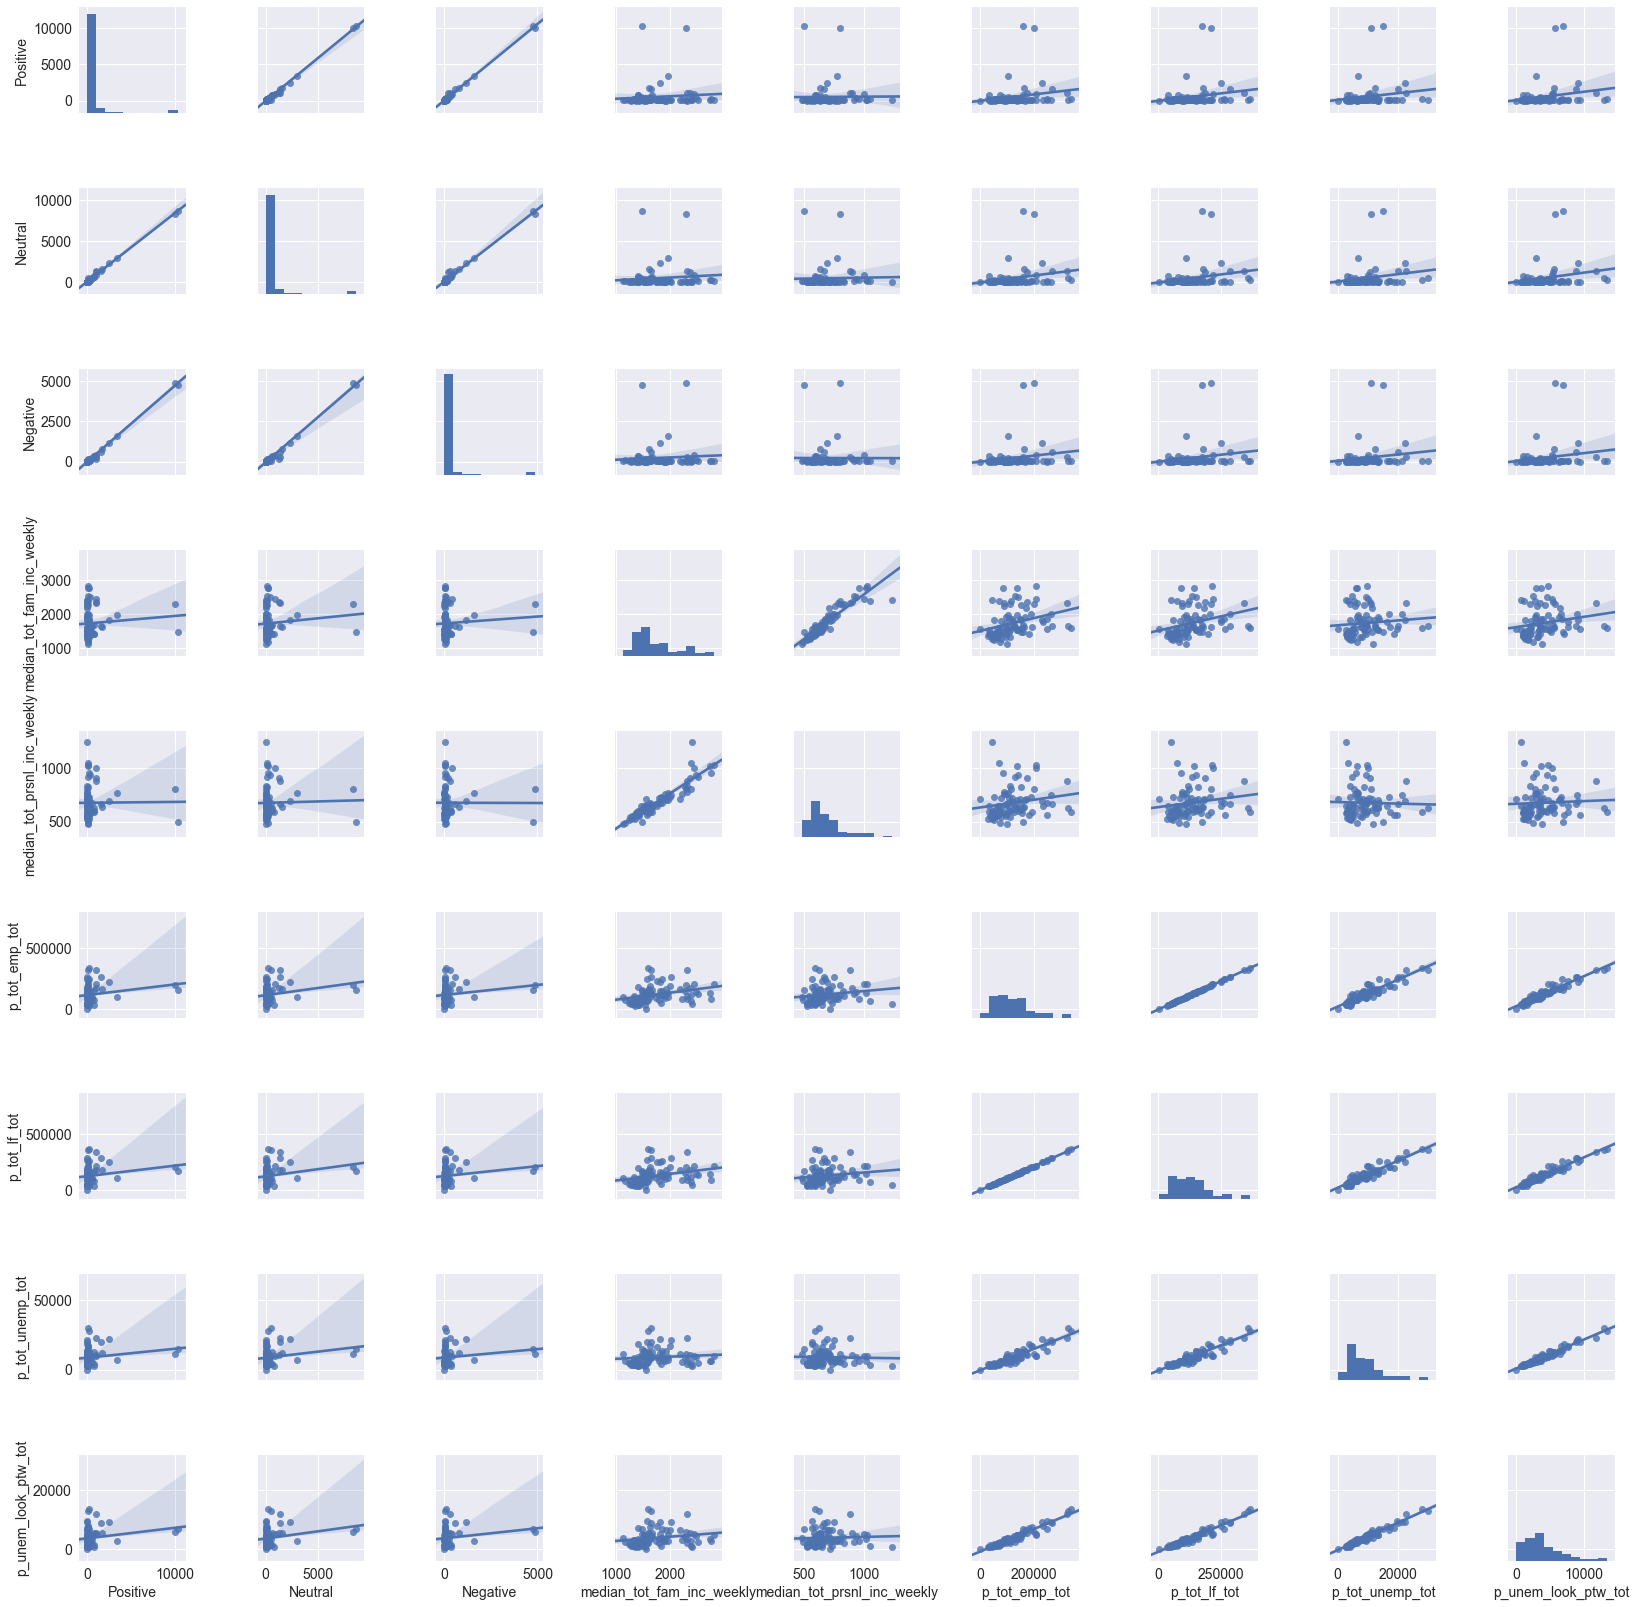

In [25]:
sns.pairplot(sa4_df, kind='reg')

# Sentiment By States

In [28]:
sa4_sentiment_df.head()

sentiment,Positive,Neutral,Negative
sa4_area,,,
Adelaide - Central and Hills,208,258,43
Adelaide - North,62,57,22
Adelaide - South,1750,1549,788
Adelaide - West,28,31,11
Australian Capital Territory,988,852,435


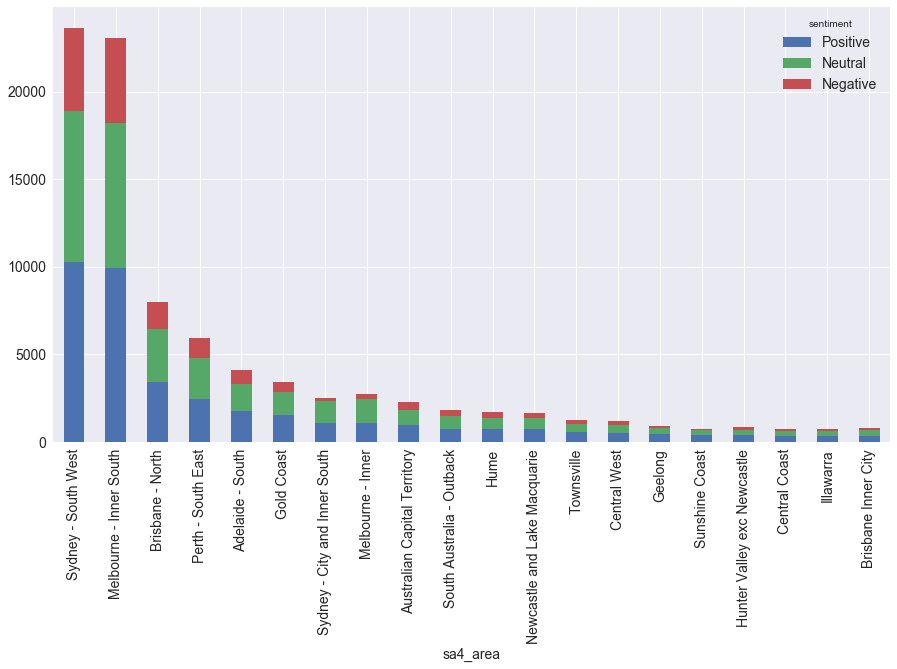

In [29]:
plot_df = sa4_sentiment_df.sort_values('Positive', ascending=False).iloc[:20]
plot_df.plot.bar(stacked=True)
plt.show()

In [30]:
totals = plot_df.sum(axis=1)
for idx in plot_df.index.values:
    plot_df.loc[idx] = plot_df.loc[idx] / totals.loc[idx] 

In [31]:
plot_df

sentiment,Positive,Neutral,Negative
sa4_area,,,
Sydney - South West,0.43,0.36,0.20
Melbourne - Inner South,0.43,0.36,0.21
Brisbane - North,0.43,0.37,0.20
Perth - South East,0.42,0.39,0.19
Adelaide - South,0.43,0.38,0.19
Gold Coast,0.45,0.38,0.17
Sydney - City and Inner South,0.43,0.50,0.07
Melbourne - Inner,0.39,0.50,0.11
Australian Capital Territory,0.43,0.37,0.19


In [23]:
#* 100

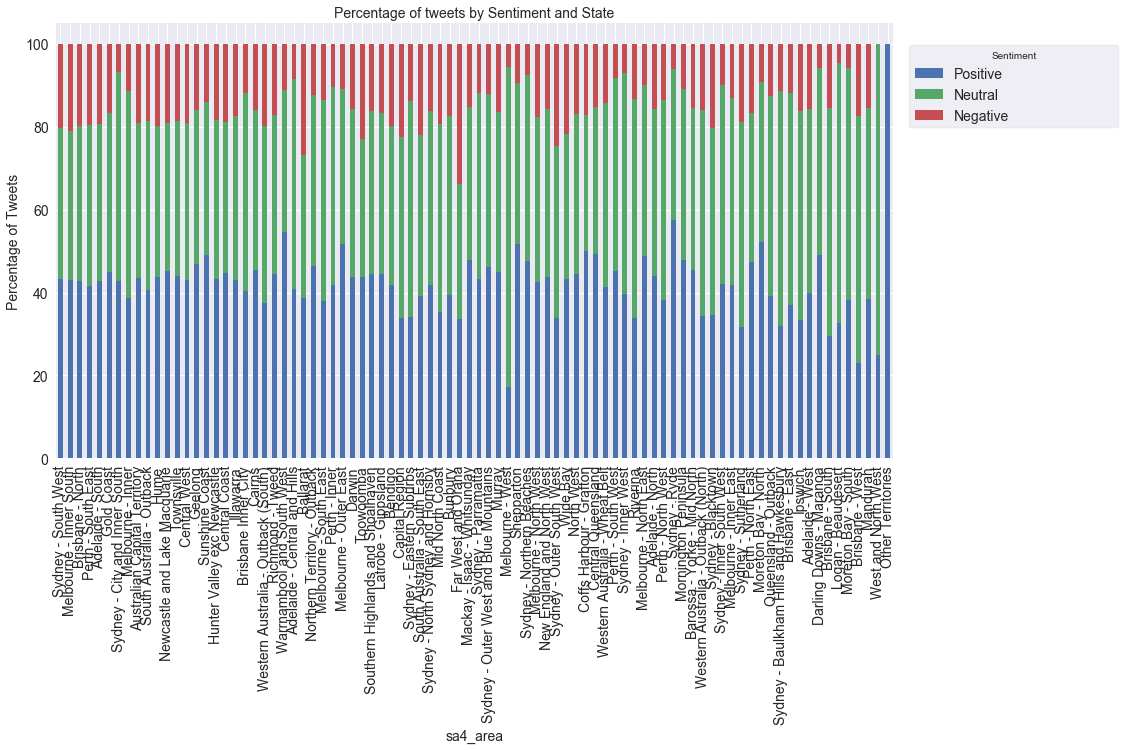

sentiment,Positive,Neutral,Negative
sa4_area,,,
Sydney - South West,43%,36%,20%
Melbourne - Inner South,43%,36%,21%
Brisbane - North,43%,37%,20%
Perth - South East,42%,39%,19%
Adelaide - South,43%,38%,19%
Gold Coast,45%,38%,17%
Sydney - City and Inner South,43%,50%,7%
Melbourne - Inner,39%,50%,11%
Australian Capital Territory,43%,37%,19%


In [24]:
plot_df.plot.bar(stacked=True)
ax = plt.gca()
ax.legend(frameon=True, loc=2, bbox_to_anchor=(1.02, 0.0,.25, .95), mode='expand', borderaxespad=0.,
                      title='Sentiment')
ax.set_title('Percentage of tweets by Sentiment and State')
ax.set_ylabel('Percentage of Tweets')
plt.show()
plot_df.applymap(lambda x: '{:.0f}%'.format(x))